# Homework 4: K means and PCA

## Setup

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from yellowbrick.cluster import SilhouetteVisualizer


## Data Preprocessing

In this Colab, rather than downloading a file from Google Drive, we will load a famous machine learning dataset, the [Breast Cancer Wisconsin dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), using the ```scikit-learn``` datasets loader.

In [78]:
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix
from sklearn.decomposition import PCA, TruncatedSVD

In [79]:
#Shape of data (X) and target (Y) values

breast_cancer = load_breast_cancer()
print(breast_cancer.target.shape)
print(breast_cancer.data.shape)
print(breast_cancer.feature_names)

(569,)
(569, 30)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


For convenience, given that the dataset is small, we first construct a Pandas dataframe and a Numpy array:
*   ```features```, a dataframe of Dense vectors, containing all the original features in the dataset;
*   ```labels```, a series of binary labels indicating if the corresponding set of features belongs to a subject with breast cancer, or not.



In [80]:
features = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
features.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [81]:
name = ['label']
labels = breast_cancer.target
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 

# Task 1: K-means (25 points)

If you run successfully the Setup and Data Preprocessing stages, you are now ready to cluster the data with the [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm included sklearn.
Set the ```k``` parameter to **2**, fit the model, and the compute the [Silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) (i.e., a measure of quality of the obtained clustering).  

**IMPORTANT:** use sklearn implementation of the Silhouette score (via ```sklearn.metrics```).

In [82]:
#YOUR CODE HERE
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
y_label = kmeans.predict(features)
silh_score = silhouette_score(features, y_label)

In [83]:
print('The silhoutte score for the generated model is ', silh_score)

The silhoutte score for the generated model is  0.6972646156059464


Take the predictions produced by K-means, and compare them with the ```labels``` variable (i.e., the ground truth from our dataset).  

For each cluster, compute how many data points in the dataset have been positive cases and negative cases. Based on this, use your judgement to determine which cluster should be assigned which label, and how many points have been labeled correctly.

**IMPORTANT**: K-means is a clustering algorithm, so it will not output a label for each data point, but just a cluster identifier!  As such, label ```0``` does not necessarily match the cluster identifier ```0```.


In [100]:
confusion_matrix(labels, y_label)

array([[ 82, 130],
       [356,   1]])

From the above matrix, we can see that the confusion matrix seems to be mirrored i.e. the cluster number 0 is actually the label 1 and cluster number 1 is actually the label 0. Hence, while creating the confusion matrix, we can directly subtract the y_label from 1 to get the actual confusion matrix.

In [85]:
confusion_matrix(labels, 1- y_label)

array([[130,  82],
       [  1, 356]])

We can also calculate manually by checking at the labels.

In [86]:
count_00 = 0
count_01 = 0
count_10 = 0
count_11 = 0
for l, r in zip(y_label, labels):
    if l == 0:
        if r == 1:
            count_00 += 1
        elif r == 0:
            count_01 += 1
    else:
        if r == 1:
            count_10 += 1
        elif r == 0:
            count_11 += 1

In [87]:
print('The confusion matrix is:')
print('The label 0 correctly classified as 0: ', count_00)
print('The label 0 incorrectrly classified as 1: ', count_01)
print('The label 1 incorrectrly classified as 0: ', count_10)
print('The label 1 correctly classified as 1: ', count_11)

The confusion matrix is:
The label 0 correctly classified as 0:  356
The label 0 incorrectrly classified as 1:  82
The label 1 incorrectrly classified as 0:  1
The label 1 correctly classified as 1:  130


# Task 2: PCA (10 points)

Now perform dimensionality reduction on the ```features``` using the [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) statistical procedure, available in sklearn.

Set the ```n``` parameter to **2**, effectively reducing the dataset size of a **15X** factor: from 30 features to just 2.

In [88]:
# YOUR CODE HERE
pca_model_features = PCA(n_components=2).fit_transform(features)

In [89]:
pca_model_features

array([[1160.1425737 , -293.91754364],
       [1269.12244319,   15.63018184],
       [ 995.79388896,   39.15674324],
       ...,
       [ 314.50175618,   47.55352518],
       [1124.85811531,   34.12922497],
       [-771.52762188,  -88.64310636]])

Now run K-means with the same parameters as above, but on the ```pcaFeatures``` produced by the PCA reduction you just executed and compute the Silhouette score.

In [90]:
# YOUR CODE HERE
kmeans_pca = KMeans(n_clusters=2, random_state=0).fit(pca_model_features)
y_label_pca = kmeans_pca.predict(pca_model_features)
silh_score_pca = silhouette_score(pca_model_features, y_label_pca)

In [91]:
print("Silhouette score using PCA: ",silh_score_pca)

Silhouette score using PCA:  0.6984195775999955


Use the 2 features generated from your PCA to visualize the clusters. Since we have used PCA to bring down th number of features to 2, they can be visualized in a x-y scatter plot. Also plot the centroids generated from the k-means on the same plot.
Make sure to give different colors to the two clusters based on their cluster labels generated by k-means.

HINT: Read the documentation for the scatter() function.

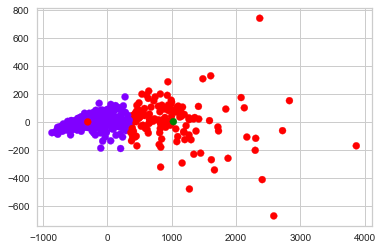

In [92]:
# YOUR CODE HERE
x = pca_model_features.T[0]
y = pca_model_features.T[1]
centroid_x , centroid_y= kmeans_pca.cluster_centers_.T

plt.scatter(x,y, c=y_label_pca, cmap='rainbow')
plt.scatter(centroid_x,centroid_y, c = ['red', 'green'])
plt.show()

# Task 3: SVD (10 points)

Perform all the tasks you did in Task 2, just instead of PCA, use sklearn to perform [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), again with n = 2

In [93]:
# YOUR CODE HERE
svd_model_features = TruncatedSVD(n_components=2).fit_transform(features)

In [94]:
kmeans_svd = KMeans(n_clusters=2, random_state=0).fit(svd_model_features)
y_label_svd = kmeans_svd.predict(svd_model_features)
silh_score_svd = silhouette_score(svd_model_features, y_label_svd)

In [95]:
print("Silhouette score using SVD is ", silh_score_svd)

Silhouette score using SVD is  0.6988822510646757


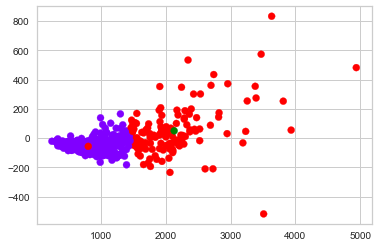

In [96]:
# YOUR CODE HERE
x = svd_model_features.T[0]
y = svd_model_features.T[1]
centroid_x , centroid_y= kmeans_svd.cluster_centers_.T

plt.scatter(x,y, c=y_label, cmap='rainbow')
plt.scatter(centroid_x,centroid_y, c = ['red', 'green'])
plt.show()

If you have done all the 3 tasks correctly, you should notice that the silhouette score for all 3 methods is almost the same. This is because we have restricted the number of clusters to two. And while there are binary labels, this dataset has 30 features, and breast cancer cases depend on a variable range of data, and hence splitting them into more clusters helps us learn more about the similarities in each cluster. 

Your last take focuses on that!

# Task 4: Comparative Analysis to Determine Best value of K (25 points)

For this entire section, use the original data before running any dimensionality reduction algorithms (features, labels).

Run k-means for ```k=2,3,4,5```, calculate the silhouette score and plot the data with the help of ```SilhouetteVisualizer``` from [yellowbricks](https://www.scikit-yb.org/en/latest/index.html). Yellowbrick extends the Scikit-Learn API to make model selection and hyperparameter tuning easier. Under the hood, it’s using Matplotlib.

**HINT:** Read up about how the Silhouette plot should look, SilhouetteVisualizer is a very particular plot, which makes understanding the score and clusters intuitive.

The y-axis denotes the number of examples, and x-axis denotes the silhouette score for the various clusters with a line depiciting the average silhouette scores.

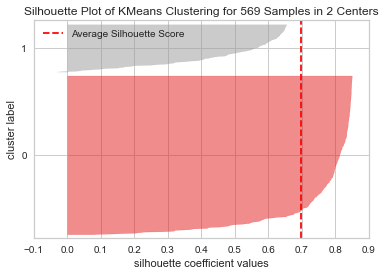

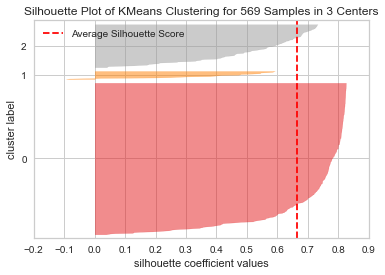

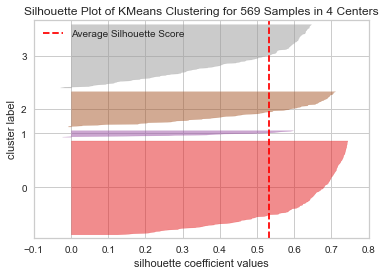

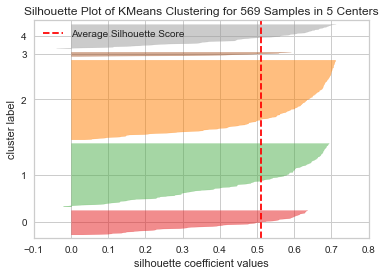

In [97]:
# YOUR CODE HERE
K = np.array([2,3,4,5])
for k in K:
    model = SilhouetteVisualizer(KMeans(k))
    model.fit(features)
    model.show()

Based on your 4 plots, write how many number of clusters is optimal and why?

Make sure your answer is based on reasoning covering the following points:


*   Average silhouette score
*   Thickness of silhouette plots for various clusters
*   Fluctuations in size of the silhouette plots




Ans: We can see from the graph that for k=2 and 3, the maximum value of the silhoutte plots is less than the average silhouette score. Hence, we can discard those. For the other two, the thickness of the plot is quite varying. Altough for k=4, the thickness is quite unstable. For k=5, we can see that 2 clusters have a larger thickness but somewhat the same value and 2 other are thin but almost of similar value. Hence i think 5 clusters is the best option since the fluctuations are uite less than in 4 clusters

# Task 5: CUR Decomposition (30 points)

Implement CUR Decomposition for the ```features``` matrix. 


*   For matrix C and R use the Column Select Algorithm to choose the columns and rows for C and R respectively. 
*   For matrix U, find the intersection between the matrices C and R, and then find its pseudo-inverse using ```numpy.linalg.pinv```

Choose the rank to be 2. Hence the order of your matrices should be:


*   C: (569 X 2)
*   U: (2 X 2)
*   R: (2 X 30)





In [98]:
from numpy.linalg import pinv as inv

def cur(matrix, rank):
	
	"""
	INPUT: matrix: features matrix m X n, rank: desired rank.
	OUTPUT: returns C, U and R resulting from the CUR decomposition of the matrix.
			Matrix C : m X rank
			Matrix U : rank X rank
			Matrix R : rank X n
	"""
	#YOUR CODE HERE
	m,n = matrix.shape
	C = np.empty((m,rank)).T
	U = np.empty((rank,rank))
	R = np.empty((rank,n))
	col_sum = np.square(matrix).sum(axis=0)
	row_sum = np.square(matrix).sum(axis=1)
	total = col_sum.sum()
	col_prob = col_sum/total
	row_prob = row_sum/total
	columns_picked = []
	rows_picked = []
	for i in range(rank):
		j = random.randint(0,matrix.shape[1]-1)
		columns_picked.append(j)
		C[i] =  matrix.T[j]/np.sqrt(rank * col_prob[j])
		k = random.randint(0,matrix.shape[0]-1)
		rows_picked.append(k)
		R[i] =  matrix[k]/np.sqrt(rank * row_prob[k])
	#print(columns_picked)
	#print(rows_picked)
	for i in range(len(columns_picked)):
		for j in range(len(rows_picked)):
				U[j][i]=matrix[rows_picked[j]][columns_picked[i]]
	
	U = np.square(np.linalg.pinv(U))
	return C.T, U, R
		


In [99]:
cur(breast_cancer.data, 2)

(array([[1121.35768869, 1121.35768869],
        [ 388.1863579 ,  388.1863579 ],
        [ 799.7473782 ,  799.7473782 ],
        ...,
        [ 987.16208217,  987.16208217],
        [1485.33457481, 1485.33457481],
        [   0.        ,    0.        ]]),
 array([[301.33099262,  77.51859273],
        [301.33099262,  77.51859273]]),
 array([[2.43779988e+02, 2.71756967e+02, 1.55095680e+03, 1.33365988e+04,
         1.14108048e+00, 9.12918707e-01, 9.90466548e-01, 7.59995996e-01,
         2.89140721e+00, 6.82448156e-01, 7.47773044e+00, 1.64874042e+01,
         4.55916111e+01, 7.33920365e+02, 5.46501767e-02, 1.14379669e-01,
         3.11142035e-01, 1.33949973e-01, 6.80954240e-01, 2.58311720e-02,
         2.79498170e+02, 3.77960839e+02, 1.75467267e+03, 1.71257139e+04,
         1.45588940e+00, 1.63244315e+00, 3.05437991e+00, 1.60935535e+00,
         6.63027243e+00, 8.29938444e-01],
        [3.54111375e+02, 2.86325088e+02, 2.30080790e+03, 1.46355566e+04,
         3.37884542e+00, 2.74024102e+00, 